# Categorical encodings

In [96]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import matplotlib.pyplot as plt

In [4]:
# Label encoding is simply converting each value in a column to a number (0 to num_classes).
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Car (toy) dataset 
https://archive.ics.uci.edu/ml/datasets/Car+Evaluation
wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data

In [8]:
data = pd.read_csv("car.data", header=None)
data.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [9]:
Y = data.iloc[:, 6].values
Y

array(['unacc', 'unacc', 'unacc', ..., 'unacc', 'good', 'vgood'],
      dtype=object)

In [10]:
data.columns

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

In [11]:
X = data.drop([6], axis=1)

In [12]:
X.head()

,0,1,2,3,4,5
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=3)
X_train.head()

,0,1,2,3,4,5
1223,med,low,3,2,big,high
1517,low,med,2,2,med,high
126,vhigh,high,2,more,small,low
1715,low,low,5more,4,med,high
58,vhigh,vhigh,4,2,med,med


In [14]:
X_train.dtypes

0    object
1    object
2    object
3    object
4    object
5    object
dtype: object

In [18]:
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

In [19]:
for col in X_train.columns:
    if X_train.dtypes[col] == "object":
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_val[col] = le.transform(X_val[col])

In [20]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [21]:
y_train

array([2, 2, 2, ..., 1, 2, 3])

In [22]:
X_train.head()

,0,1,2,3,4,5
0,2,1,1,0,0,0
1,1,2,0,0,1,0
2,3,0,0,2,2,1
3,1,1,3,1,1,0
4,3,3,2,0,1,2


In [23]:
X_val.head()

,0,1,2,3,4,5
0,3,1,0,2,0,0
1,3,0,0,0,1,2
2,2,0,1,1,1,1
3,0,2,2,1,1,2
4,2,1,3,1,2,0


In [24]:
X_train.shape

(1382, 6)

In [25]:
[np.unique(X_train[col].values) for col in X_train]

[array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2])]

In [26]:
cat_levels = [len(np.unique(X_train[col].values)) for col in X_train]
cat_levels 

[4, 4, 4, 3, 3, 3]

## Embedding layer
Most deep learning models use a dense vectors of real numbers as representation of words or categorical variables, as opposed to a one-hot encoding representations. The module torch.nn.Embedding is used to represent word embeddings. It takes two arguments: number of levels in your categorical variable, and the dimensionality of the embeddings. The embeddings are initialized with random vectors and are learned in the training process.

In [27]:
# An Embedding layer containing 4 categories and embedding size 5. 
# Embeddings will be initialized at random.
embed = nn.Embedding(4, 5)
embed.weight

Parameter containing:
tensor([[-1.4497,  0.1786, -1.1235, -1.5645, -1.5388],
        [ 2.0144, -1.5969, -0.5350, -0.6747, -0.2926],
        [-1.5135, -0.4365, -0.6584, -0.1974, -0.0570],
        [-0.2185,  0.0166, -0.5123, -0.9503, -0.0153]], requires_grad=True)

In [28]:
# Each categotical variable with K levels should be relabel with levels between 0 and K-1.
# Given a coulmn x, to "look up" the embedding of each level do:
# Note that it needs type LongTensor
x = torch.LongTensor([1, 0, 1, 3, 3 , 2])
embed(x)

tensor([[ 2.0144, -1.5969, -0.5350, -0.6747, -0.2926],
        [-1.4497,  0.1786, -1.1235, -1.5645, -1.5388],
        [ 2.0144, -1.5969, -0.5350, -0.6747, -0.2926],
        [-0.2185,  0.0166, -0.5123, -0.9503, -0.0153],
        [-0.2185,  0.0166, -0.5123, -0.9503, -0.0153],
        [-1.5135, -0.4365, -0.6584, -0.1974, -0.0570]],
       grad_fn=<EmbeddingBackward>)

## Model

In [29]:
class TabularModel(nn.Module):
    def __init__(self, cat_levels, emb_size=5, n_class=4):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, emb_size) for c in cat_levels])
        self.lin1 = nn.Linear(6*emb_size, 20)
        self.lin2 = nn.Linear(20, n_class)
        self.bn = nn.BatchNorm1d(20)
        self.emb_drop = nn.Dropout(0.1)
        self.drops = nn.Dropout(0.1)

    def forward(self, x):
        # try to write a shorter code
        e0 = self.embs[0](x[:,0])
        e1 = self.embs[1](x[:,1])
        e2 = self.embs[2](x[:,2])
        e3 = self.embs[3](x[:,3])
        e4 = self.embs[4](x[:,4])
        e5 = self.embs[5](x[:,5])
        x = torch.cat([e0, e1, e2, e3, e4, e5], 1)
        x = self.emb_drop(x)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn(x)
        x = self.lin2(x)
        return x

In [30]:
model = TabularModel(cat_levels)

In [31]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    return optim

In [32]:
x_train = torch.LongTensor(X_train.values)
y_train = torch.LongTensor(y_train)

In [34]:
def train_model(model, optim, epochs=5):
    for i in range(epochs):
        model.train()
        out = model(x_train)
        loss = F.cross_entropy(out, y_train)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        val_loss, val_acc = val_metric(model)
        if i % 15 == 0: 
            print("train loss %.3f val loss %.3f and accuracy %.3f" % 
                  (loss, val_loss, val_acc))

In [35]:
x_val = torch.LongTensor(X_val.values)
y_val = torch.LongTensor(y_val)

In [36]:
def val_metric(model):
    model.eval()
    correct = 0
    out = model(x_val)
    loss = F.cross_entropy(out, y_val)
    pred = torch.max(out, 1)[1]
    correct += (pred == y_val).float().sum().item()
    return loss, correct/y_val.shape[0]

In [37]:
model = TabularModel(cat_levels)
optim = get_optimizer(model, lr = 0.01, wd = 0.0)

In [38]:
train_model(model, optim, epochs=150)

train loss 1.448 val loss 1.361 and accuracy 0.332
train loss 0.602 val loss 0.573 and accuracy 0.792
train loss 0.333 val loss 0.273 and accuracy 0.896
train loss 0.221 val loss 0.173 and accuracy 0.951
train loss 0.174 val loss 0.139 and accuracy 0.962
train loss 0.145 val loss 0.112 and accuracy 0.974
train loss 0.142 val loss 0.101 and accuracy 0.968
train loss 0.115 val loss 0.081 and accuracy 0.986
train loss 0.129 val loss 0.087 and accuracy 0.971
train loss 0.109 val loss 0.079 and accuracy 0.968


# WiDS 2018  dataset

The data for this part of the notebook comes from this kaggle [competition](https://www.kaggle.com/c/wids2018datathon/). You are given a dataset of survey questions and results from a developing country. Your goal is to predict the gender of the respondent based on the other answers he/she provided. You Kaggle api to get the data. All variables in this dataset and categorical.

`pip install kaggle` <br/>

`kaggle competitions download -c wids2018datathon -p /path/to/data`

In [39]:
train = pd.read_csv("train.csv", low_memory=False)
train.head()

,train_id,AA3,AA4,AA5,AA6,AA7,AA14,AA15,DG1,is_female,...,GN1,GN1_OTHERS,GN2,GN2_OTHERS,GN3,GN3_OTHERS,GN4,GN4_OTHERS,GN5,GN5_OTHERS
0,0,3,32,3.0,NaN,323011,3854,481,1975,1,...,99.0,NaN,99,NaN,99,NaN,99,NaN,99,NaN
1,1,2,26,NaN,8.0,268131,2441,344,1981,1,...,NaN,NaN,1,NaN,2,NaN,2,NaN,2,NaN
2,2,1,16,NaN,7.0,167581,754,143,1995,1,...,1.0,NaN,2,NaN,2,NaN,2,NaN,2,NaN
3,3,4,44,5.0,NaN,445071,5705,604,1980,1,...,NaN,NaN,2,NaN,2,NaN,99,NaN,99,NaN
4,4,4,43,NaN,6.0,436161,5645,592,1958,1,...,NaN,NaN,1,NaN,1,NaN,1,NaN,1,NaN


In [40]:
train.shape

(18255, 1235)

In [41]:
# train id looks like a unique id for each row
train = train.drop(columns=["train_id"])
train.head()

,AA3,AA4,AA5,AA6,AA7,AA14,AA15,DG1,is_female,DG3,...,GN1,GN1_OTHERS,GN2,GN2_OTHERS,GN3,GN3_OTHERS,GN4,GN4_OTHERS,GN5,GN5_OTHERS
0,3,32,3.0,NaN,323011,3854,481,1975,1,3,...,99.0,NaN,99,NaN,99,NaN,99,NaN,99,NaN
1,2,26,NaN,8.0,268131,2441,344,1981,1,8,...,NaN,NaN,1,NaN,2,NaN,2,NaN,2,NaN
2,1,16,NaN,7.0,167581,754,143,1995,1,3,...,1.0,NaN,2,NaN,2,NaN,2,NaN,2,NaN
3,4,44,5.0,NaN,445071,5705,604,1980,1,3,...,NaN,NaN,2,NaN,2,NaN,99,NaN,99,NaN
4,4,43,NaN,6.0,436161,5645,592,1958,1,3,...,NaN,NaN,1,NaN,1,NaN,1,NaN,1,NaN


## Cleaning columns with too many NAs

In [42]:
train["AA5"].isnull().sum()

12602

In [43]:
# counting the number of NULL in per column
train.isnull().sum()

AA3               0
AA4               0
AA5           12602
AA6            5653
AA7               0
              ...  
GN3_OTHERS    18172
GN4               0
GN4_OTHERS    18169
GN5               0
GN5_OTHERS    18179
Length: 1234, dtype: int64

In [44]:
## dropping columns with too many nulls
for col in train.columns:
    if train[col].isnull().sum() > 12000:
        train.drop(col, axis=1, inplace=True)

In [45]:
# just kept 421 columns
train.head()

,AA3,AA4,AA6,AA7,AA14,AA15,DG1,is_female,DG3,DG3A,...,LN2_2,LN2_3,LN2_4,LN2_RIndLngBEOth,LN2_WIndLngBEOth,GN1,GN2,GN3,GN4,GN5
0,3,32,NaN,323011,3854,481,1975,1,3,4,...,1,1,1,NaN,NaN,99.0,99,99,99,99
1,2,26,8.0,268131,2441,344,1981,1,8,4,...,1,3,4,Bengali,Bengali,NaN,1,2,2,2
2,1,16,7.0,167581,754,143,1995,1,3,2,...,1,2,2,Hindi,Hindi,1.0,2,2,2,2
3,4,44,NaN,445071,5705,604,1980,1,3,4,...,1,4,5,Tamil,Tamil,NaN,2,2,99,99
4,4,43,6.0,436161,5645,592,1958,1,3,4,...,4,4,4,Malayalam,Malayalam,NaN,1,1,1,1


In [48]:
train.shape

(18255, 421)

In [49]:
# save to a csv
train.to_csv("train_421_cols.csv", index=False)

## Picking columns for embeddings

In [50]:
train = pd.read_csv("train_421_cols.csv")

In [51]:
# Saving the label into another variable, dropping from main dataframe
Y = train["is_female"].values.astype(np.float32)
X = train.drop(columns=["is_female"])

In [52]:
# filling NAs and doing label encoding
# Label encoding is simply converting each value in a column to a number (0 to num_classes).
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
for col in X.columns:
    if X.dtypes[col] == "object":
        X[col] = X[col].fillna("NA")
    else:
        X[col] = X[col].fillna(0)
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [53]:
# telling pandas that all the variables are categorical
for col in X.columns:
    X[col] = X[col].astype('category')

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=3)
X_train.head()

,AA3,AA4,AA6,AA7,AA14,AA15,DG1,DG3,DG3A,DG4,...,LN2_2,LN2_3,LN2_4,LN2_RIndLngBEOth,LN2_WIndLngBEOth,GN1,GN2,GN3,GN4,GN5
11369,1,10,2,424,482,252,62,2,3,4,...,0,0,0,38,38,0,1,1,1,1
1250,2,17,1,831,831,410,63,2,3,5,...,0,3,3,33,32,1,2,2,0,0
7527,1,8,0,301,310,166,53,2,3,0,...,0,0,0,38,38,2,1,1,1,1
13476,2,14,2,664,564,300,69,2,3,4,...,2,2,2,14,14,3,2,2,2,2
13406,0,12,3,587,111,76,58,2,3,2,...,1,3,3,14,14,1,0,2,2,2


In [55]:
# variables with two values are fine 
# number of values for variables with more than 2 values
emb_c = {n: len(col.cat.categories) for n,col in X.items() if len(col.cat.categories) > 2}
emb_c

{'AA3': 4,
 'AA4': 22,
 'AA6': 4,
 'AA7': 1050,
 'AA14': 907,
 'AA15': 450,
 'DG1': 79,
 'DG3': 9,
 'DG3A': 8,
 'DG4': 12,
 'DG6': 9,
 'DG8a': 13,
 'DG8b': 13,
 'DG8c': 13,
 'DG9a': 12,
 'DG9b': 11,
 'DG9c': 8,
 'DG10b': 9,
 'DG10c': 8,
 'DG11b': 9,
 'DL1': 12,
 'DL2': 33,
 'DL3': 3,
 'DL5': 25,
 'DL7': 3,
 'DL8': 342,
 'DL11': 15,
 'DL14': 24,
 'DL15': 4,
 'DL24': 7,
 'MT1': 13,
 'MT1A': 8,
 'MT3_1': 5,
 'MT3_2': 6,
 'MT3_3': 6,
 'MT4_1': 3,
 'MT4_2': 3,
 'MT4_3': 3,
 'MT4_4': 3,
 'MT4_5': 3,
 'MT4_6': 3,
 'MT5': 8,
 'MT6': 10,
 'MT6A': 7,
 'MT6B': 9,
 'MT6C': 28,
 'MT7': 3,
 'MT11': 83,
 'MT12_1': 5,
 'MT12_2': 7,
 'MT12_3': 6,
 'MT12_4': 3,
 'MT12_5': 3,
 'MT12_7': 5,
 'MT12_9': 3,
 'MT12_11': 5,
 'MT12_12': 3,
 'MT12_13': 3,
 'MT12_14': 3,
 'MT14C_1': 5,
 'MT14C_2': 5,
 'MT14C_3': 5,
 'MT14C_4': 5,
 'MT15': 3,
 'MT17_1': 7,
 'MT17_2': 7,
 'MT17_3': 7,
 'MT17_4': 7,
 'MT17_5': 7,
 'MT17_6': 7,
 'MT17_7': 7,
 'MT17_8': 7,
 'MT17_9': 7,
 'MT17_10': 7,
 'MT17_11': 7,
 'MT17_12': 7,
 'M

In [63]:
# size of the category, size of the embedding
# 30 and (c+1)//2) are arbitrary (we should play with these numbers)
emb_szs = [(c, min(20, (c+1)//2)) for _,c in emb_c.items()]
emb_szs

[(4, 2),
 (22, 11),
 (4, 2),
 (1050, 20),
 (907, 20),
 (450, 20),
 (79, 20),
 (9, 5),
 (8, 4),
 (12, 6),
 (9, 5),
 (13, 7),
 (13, 7),
 (13, 7),
 (12, 6),
 (11, 6),
 (8, 4),
 (9, 5),
 (8, 4),
 (9, 5),
 (12, 6),
 (33, 17),
 (3, 2),
 (25, 13),
 (3, 2),
 (342, 20),
 (15, 8),
 (24, 12),
 (4, 2),
 (7, 4),
 (13, 7),
 (8, 4),
 (5, 3),
 (6, 3),
 (6, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (8, 4),
 (10, 5),
 (7, 4),
 (9, 5),
 (28, 14),
 (3, 2),
 (83, 20),
 (5, 3),
 (7, 4),
 (6, 3),
 (3, 2),
 (3, 2),
 (5, 3),
 (3, 2),
 (5, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (5, 3),
 (5, 3),
 (5, 3),
 (5, 3),
 (3, 2),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (18, 9),
 (27, 14),
 (3, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (5, 3),
 (4, 2),
 (3, 2),
 (7, 4),
 (3, 2

In [64]:
emb_cols = emb_c.keys()
emb_cols

dict_keys(['AA3', 'AA4', 'AA6', 'AA7', 'AA14', 'AA15', 'DG1', 'DG3', 'DG3A', 'DG4', 'DG6', 'DG8a', 'DG8b', 'DG8c', 'DG9a', 'DG9b', 'DG9c', 'DG10b', 'DG10c', 'DG11b', 'DL1', 'DL2', 'DL3', 'DL5', 'DL7', 'DL8', 'DL11', 'DL14', 'DL15', 'DL24', 'MT1', 'MT1A', 'MT3_1', 'MT3_2', 'MT3_3', 'MT4_1', 'MT4_2', 'MT4_3', 'MT4_4', 'MT4_5', 'MT4_6', 'MT5', 'MT6', 'MT6A', 'MT6B', 'MT6C', 'MT7', 'MT11', 'MT12_1', 'MT12_2', 'MT12_3', 'MT12_4', 'MT12_5', 'MT12_7', 'MT12_9', 'MT12_11', 'MT12_12', 'MT12_13', 'MT12_14', 'MT14C_1', 'MT14C_2', 'MT14C_3', 'MT14C_4', 'MT15', 'MT17_1', 'MT17_2', 'MT17_3', 'MT17_4', 'MT17_5', 'MT17_6', 'MT17_7', 'MT17_8', 'MT17_9', 'MT17_10', 'MT17_11', 'MT17_12', 'MT17_13', 'MT18_1', 'MT18_2', 'MT18_3', 'MT18_4', 'MT18_5', 'MT18_6', 'MT18_96', 'MT18_8', 'FF2', 'FF2A', 'FF3', 'FF4', 'FF5', 'FF6_1', 'FF6_2', 'FF6_3', 'FF6_4', 'FF6_5', 'FF6_6', 'FF6_7', 'FF6_8', 'FF6_9', 'FF6_10', 'FF7_1', 'FF7_2', 'FF7_4', 'FF7_5', 'FF7_6', 'FF9', 'FF10_1', 'FF10_2', 'FF10_3', 'FF10_4', 'FF10_5', '

## Dataset
Dataset is a custom class to conveniently interact with a set observations. Designing this Dataset class is up to you.

In [65]:
# all variables are categorical, but some of them has just two values 
# emb_c are the variables we plan to embed
class WiDSDataset(Dataset):
    def __init__(self, X, Y, emb_cols):
        X = X.copy()
        # splitting categorical columns and numerical columns
        self.X1 = X.loc[:,emb_cols].copy().values.astype(np.int64)
        self.X2 = X.drop(columns=emb_cols).copy().values.astype(np.float32)
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

In [66]:
train_ds = WiDSDataset(X_train, y_train, emb_cols)
valid_ds = WiDSDataset(X_val, y_val, emb_cols)

In [67]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [68]:
valid_ds[0]

(array([  0,   4,   3, 200, 229, 129,  72,   0,   3,   5,   2,   5,   3,
          1,   3,   0,   0,   3,   0,   3,   5,   0,   0,   0,   1, 136,
          0,   8,   3,   0,   1,   7,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   2,   0,   0,   1,   3,
          1,   3,   2,   1,   2,   3,   2,   2,   2,   0,   0,   1,   0,
          0,   4,   1,   2,   2,   2,   2,   2,   2,   1,   1,   1,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   4,   4,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   0,   2,   2,   6,   6,   6,   6,   6,   6,
          1,   6,   6,   6,   6,   6,   6,   6,   0

## Model

In [69]:
# modified from fast.ai
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        n_emb = sum(e.embedding_dim for e in self.embs) 
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 100)
        self.lin2 = nn.Linear(100, 1)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(100)
        self.emb_drop = nn.Dropout(0.5)
        self.drops = nn.Dropout(0.2)
        

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = self.lin2(x)
        return x

In [70]:
model = MixedInputModel(emb_szs, 172)

In [71]:
embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])

In [72]:
x1, x2, y = next(iter(train_dl))
print(x1.shape, x2.shape, y.shape)

torch.Size([5, 248]) torch.Size([5, 172]) torch.Size([5])


In [73]:
x1[:,0]

tensor([1, 1, 3, 2, 0])

In [74]:
embs[0](x1[:,0])

tensor([[-2.2628, -0.9250],
        [-2.2628, -0.9250],
        [ 2.1789,  0.3396],
        [ 0.6629,  1.0533],
        [-0.1358, -0.4572]], grad_fn=<EmbeddingBackward>)

In [75]:
y = y.unsqueeze(1)
out = model(x1, x2)
out

tensor([[ 0.3648],
        [ 0.3102],
        [-0.3776],
        [-0.0326],
        [ 0.0477]], grad_fn=<AddmmBackward>)

In [76]:
out.shape

torch.Size([5, 1])

In [77]:
pred = (out > 0.0).float()

In [78]:
(pred == y).float().sum()

tensor(3.)

In [79]:
F.binary_cross_entropy_with_logits(out, y)

tensor(0.7377, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

## Training

In [80]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [81]:
def train_model(model, optim, train_dl=train_dl, verbose=False):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        y = y.unsqueeze(1)  
        out = model(x1, x2)
        loss = F.binary_cross_entropy_with_logits(out, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
        if verbose: print(sum_loss/total)
    return sum_loss/total

In [113]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        batch = y.shape[0]
        y = y.unsqueeze(1)
        out = model(x1, x2)
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = (out > 0).float()
        correct += (pred == y).float().sum().item()
    return sum_loss/total, correct/total

In [114]:
from datetime import datetime

def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train loss %.3f val loss %.3f and accuracy %.3f" % (
            loss, val_loss, val_acc))

In [115]:
batch_size = 500
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [116]:
model = MixedInputModel(emb_szs, 172) #.cuda()

In [117]:
# Try the higest learning rate that doesn't cycle 
#optim = get_optimizer(model, lr = 0.1, wd = 0.0)
#train_model(model, optim, train_dl, verbose=True)

In [118]:
train_loop(model, epochs=10, lr=0.05, wd=0.00001)

train loss 0.419 val loss 0.290 and accuracy 0.880
train loss 0.283 val loss 0.244 and accuracy 0.898
train loss 0.253 val loss 0.257 and accuracy 0.890
train loss 0.235 val loss 0.256 and accuracy 0.902
train loss 0.221 val loss 0.243 and accuracy 0.906
train loss 0.213 val loss 0.252 and accuracy 0.906
train loss 0.205 val loss 0.256 and accuracy 0.907
train loss 0.202 val loss 0.264 and accuracy 0.899
train loss 0.194 val loss 0.264 and accuracy 0.896
train loss 0.190 val loss 0.261 and accuracy 0.902


## Learning rate (LR) range test
The [learning rate range test](https://arxiv.org/abs/1506.01186) is a way to estimate minimum and maximum boundary values for learning rates.

In [122]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [123]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = "model_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for j, (x1, x2, y) in enumerate(train_dl):
            # changing learning rate at each iteration
            optim = get_optimizer(model, lr=lrs[ind])
            batch = y.shape[0]
            y = y.unsqueeze(1)  
            out = model(x1, x2)
            loss = F.binary_cross_entropy_with_logits(out, y)   
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses

In [124]:
batch_size = 500
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
model = MixedInputModel(emb_szs, 172)

In [125]:
# lr_low, lr_high and batch_size are important so that the plot gives
# useful information
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.1, epochs=4)

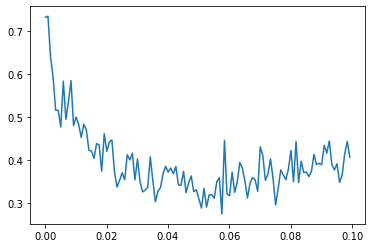

In [126]:
plt.plot(lrs, losses)
plt.show()

Pick the lower boundary as the value of the learning rate when the loss starts to decrease. Pick the upper learning rate when the loss slows, becomes ragged or increases. From this graph I would try $base\_lr=1e-4$ and $max\_lr=0.04$

In [127]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

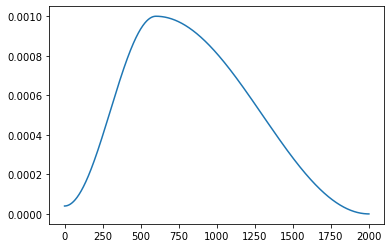

In [128]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [129]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs=4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x1, x2, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd = 0.00001)
            batch = y.shape[0]
            y = y.unsqueeze(1)  
            out = model(x1, x2)
            loss = F.binary_cross_entropy_with_logits(out, y) 
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

In [130]:
# get a new model
model = MixedInputModel(emb_szs, 172)

In [131]:
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs=10)

train loss 0.45023822681572756
val loss 0.393 and accuracy 0.856
train loss 0.3728232829416004
val loss 0.466 and accuracy 0.835
train loss 0.34141300615791553
val loss 0.296 and accuracy 0.866
train loss 0.31351019777571854
val loss 0.273 and accuracy 0.878
train loss 0.29257091015814035
val loss 0.256 and accuracy 0.890
train loss 0.27056312952032485
val loss 0.247 and accuracy 0.892
train loss 0.25537933604304547
val loss 0.246 and accuracy 0.894
train loss 0.2386973602898772
val loss 0.234 and accuracy 0.899
train loss 0.23197157010007513
val loss 0.229 and accuracy 0.907
train loss 0.22505255803461763
val loss 0.228 and accuracy 0.907


0.22505255803461763

## Lab

1. Go back and add m